In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *
from ourworldindata_org.collector import *

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch data set from local disk

In [4]:
!ls ~/data/
# gets thte latest file names
recent = ! ls -drt ~/data/* | tail -n 2
print("Latest files are:\n\t{}\n\t{}".format(*recent))

2020-04-07_2224_state_daily_data.csv 2020-04-17_0126_state_daily_data.csv
2020-04-07_2224_state_rank.csv       2020-04-17_0126_state_rank.csv
2020-04-08_2053_state_daily_data.csv 2020-04-17_0132_state_daily_data.csv
2020-04-08_2053_state_rank.csv       2020-04-17_0132_state_rank.csv
2020-04-09_1613_state_daily_data.csv 2020-04-17_0143_state_daily_data.csv
2020-04-09_1613_state_rank.csv       2020-04-17_0143_state_rank.csv
2020-04-10_1539_state_daily_data.csv 2020-04-17_2205_state_daily_data.csv
2020-04-10_1539_state_rank.csv       2020-04-17_2205_state_rank.csv
2020-04-10_1555_state_daily_data.csv 2020-04-19_2308_state_daily_data.csv
2020-04-10_1555_state_rank.csv       2020-04-19_2308_state_rank.csv
2020-04-10_2050_state_daily_data.csv 2020-04-20_1735_state_daily_data.csv
2020-04-10_2050_state_rank.csv       2020-04-20_1735_state_rank.csv
2020-04-11_1640_state_daily_data.csv 2020-04-21_0048_state_daily_data.csv
2020-04-11_1640_state_rank.csv       2020-04-21_0048_state_rank.csv
2020-0

In [5]:
df, states_in_order = get_dataset_df_from_file(recent)
df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade,order,lastUpdateEt_state,population
0,2020-03-04,NY,6.0,48.0,24.0,NaN,NaN,NaN,NaN,NaN,...,4dbef65288b7dbede2d781e28a00cba52693e213,0,0,0,0,0,NaN,0,6/2/2020 00:00,19453561.0
1,2020-03-05,NY,22.0,76.0,24.0,NaN,NaN,NaN,NaN,NaN,...,dedb5e3a7164232b7173c320f61ea4a36465eac1,0,0,0,0,0,NaN,0,6/2/2020 00:00,19453561.0
2,2020-03-06,NY,33.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,...,bbf7bd692bc61d17851948c556bc158ca53741fb,0,0,0,0,0,NaN,0,6/2/2020 00:00,19453561.0
3,2020-03-07,NY,76.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,...,295dec0f81e7a705619e4b40a8176ee039d1f7ba,0,0,0,0,0,NaN,0,6/2/2020 00:00,19453561.0
4,2020-03-08,NY,105.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,...,20c301e392da61f0fb0abbd5873de0a14d2a59e9,0,0,0,0,0,NaN,0,6/2/2020 00:00,19453561.0


### SIR Model

In [6]:
dfq = get_state_df(df, "*")
cc = CurrentCasesUndercount()
dfq = cc.add_positive_estimate(dfq)
ccd = CurrentCasesFromDeaths()
dfq = ccd.add_positive_estimate(dfq, params={"a": 250, "shift": 14})
dfq.head()

,date,positive,daily_new_positive,death,daily_new_death,tests,daily_new_positive_undercount,positive_undercount,daily_new_positive_fromdeath,positive_fromdeath
0,2020-01-22,1.0,0,0.0,0,1,0.0,0,0,0
1,2020-01-23,1.0,0,0.0,0,1,0.0,0,0,0
2,2020-01-24,1.0,0,0.0,0,1,0.0,0,0,0
3,2020-01-25,1.0,0,0.0,0,1,0.0,0,0,0
4,2020-01-26,1.0,0,0.0,0,1,0.0,0,0,0


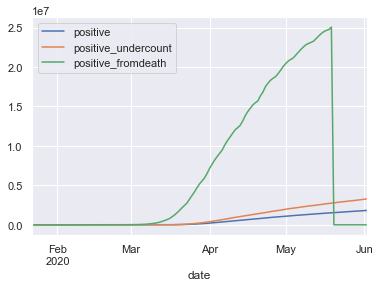

In [7]:
dfq.plot(x="date", y=["positive", "positive_undercount", "positive_fromdeath"])

,day_number,date,positive_predicted,positive,new_daily_positive,hospitalized_ident,icu_ident
132,133,2020-06-02,1846442,1823269.0,22549.0,32023,8539
133,134,2020-06-03,1869269,0.0,22827.0,32419,8645
134,135,2020-06-04,1892379,0.0,23110.0,32820,8752
135,136,2020-06-05,1915774,0.0,23395.0,33226,8860
136,137,2020-06-06,1939459,0.0,23685.0,33636,8969
137,138,2020-06-07,1963436,0.0,23977.0,34052,9080
138,139,2020-06-08,1987710,0.0,24274.0,34473,9192
139,140,2020-06-09,2012284,0.0,24574.0,34899,9306
140,141,2020-06-10,2037162,0.0,24878.0,35331,9421
141,142,2020-06-11,2062347,0.0,25185.0,35768,9538


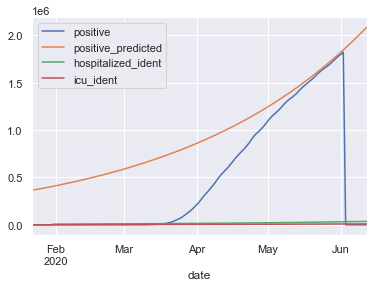

In [8]:
# Exponential Model
mp = ModelProjectionExponential()
d = mp.project(dfq, 10)
d.plot(x="date", y=["positive", "positive_predicted", "hospitalized_ident", "icu_ident"])
d.tail(11)

### SIR Fit

   direc: array([[ 2.64555763e-04,  1.73974053e-03,  8.65421070e+00],
       [-3.52095434e-04, -1.55473920e-06,  6.12997524e-04],
       [ 1.55304086e-04,  2.68617867e-04,  1.37136567e+00]])
     fun: 538476573.2877306
 message: 'Optimization terminated successfully.'
    nfev: 672
     nit: 17
  status: 0
 success: True
       x: array([ 0.16491433,  0.13159674, 95.02025429])
######################################################################
Day 0 = 2020-01-08 00:00:00  (today=133)
Doubling time is about 4.20 days
Recovery time is about 5.27 days
Estimated initial infection was order of 95,020 poeple


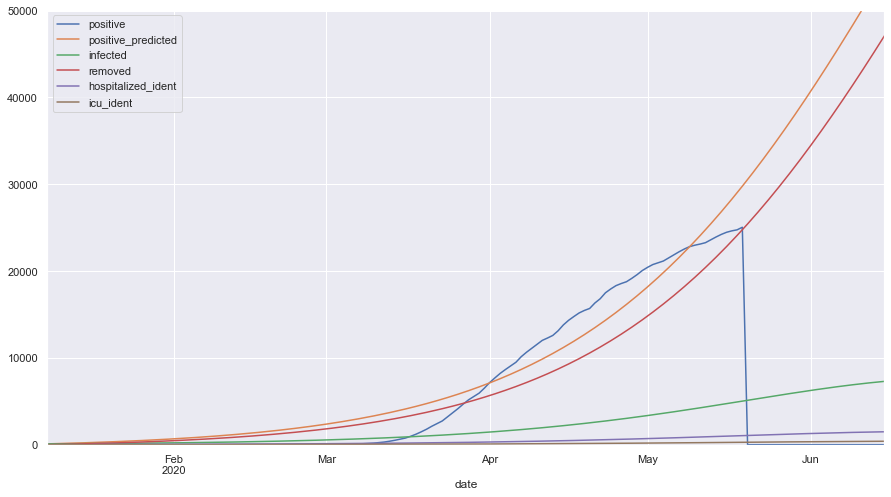

In [9]:
N=350000 
x0 = (0.25749545, 0.10952173, 3.17810689)  # beta, gamma, I0
c = ccd.fit_series/1000
start_date = dfq.date.values[0] - pd.Timedelta(days=ccd.shift)
sf = SIR()
(N, I0, R0, beta, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])

### SIR4: Try Varying beta as part of the model

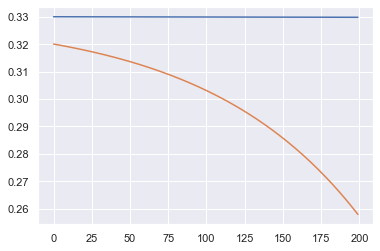

In [10]:
def g(alpha, beta0, t):
    return beta0 - alpha * t

def h(alpha, beta0, t):
    return beta0 - np.log(alpha) * alpha ** t

t = np.arange(0, 200, 1)
plt.plot(t, g(.000001, .33, t))
plt.plot(t, h(1.01, .33, t))
plt.show()

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[-6.79758126e-05,  6.38631912e-01,  6.39467426e-01,
         5.74989747e-05],
       [-1.58090479e-06, -1.78523950e-03,  7.59440603e-05,
        -2.10924031e-10],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-7.65983628e-05,  6.77637241e-01,  6.78628472e-01,
         6.13580690e-05]])
     fun: 111631586.61855374
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 4015
     nit: 67
  status: 1
 success: False
       x: array([-1.08223444e-03,  2.10103105e+01,  2.08919848e+01,  1.68795662e-03])
######################################################################
Day 0 = 2020-01-08 00:00:00  (today=133)
Doubling time is about 4.20 days
Recovery time is about 0.03 days
Estimated initial infection was order of 1 poeple


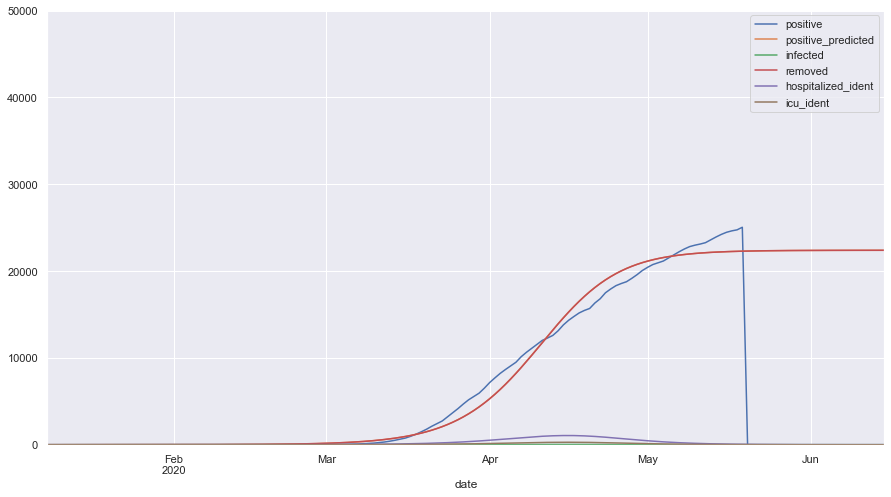

In [11]:
N=350000
x0 = (0.01313296, 0.87278724, 0.33722395, 0.01900052)  # alpha, beta0, gamma, I0
c = ccd.fit_series/1000
start_date = dfq.date.values[0] - pd.Timedelta(days=ccd.shift)
sf = SIR4()
(N, I0, R0, beta0, alpha, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta0, alpha, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])

In [12]:
dfw, wsl = get_dataset_df_from_files()
dfw.head()

,Entity,state,Date,positive,death,date,last_update,daily_new_positive,daily_new_death
0,Afghanistan,AFG,"Dec 31, 2019",0,0,2019-12-31,2020-06-03 16:52:39.687613,NaN,NaN
1,Afghanistan,AFG,"Jan 1, 2020",0,0,2020-01-01,2020-06-03 16:52:39.687613,0.0,0.0
2,Afghanistan,AFG,"Jan 2, 2020",0,0,2020-01-02,2020-06-03 16:52:39.687613,0.0,0.0
3,Afghanistan,AFG,"Jan 3, 2020",0,0,2020-01-03,2020-06-03 16:52:39.687613,0.0,0.0
4,Afghanistan,AFG,"Jan 4, 2020",0,0,2020-01-04,2020-06-03 16:52:39.687613,0.0,0.0


   direc: array([[ 2.94082070e-03, -2.22512738e-03, -9.57567286e-01],
       [ 7.18135601e-05, -1.49325746e-07,  1.03082141e-05],
       [-9.34353927e-05,  1.04407695e-04,  2.82757449e-02]])
     fun: 8350799.7962603895
 message: 'Optimization terminated successfully.'
    nfev: 272
     nit: 6
  status: 0
 success: True
       x: array([0.21442501, 0.15075992, 1.72633985])
######################################################################
Day 0 = 2020-01-08 00:00:00  (today=155)
Doubling time is about 3.23 days
Recovery time is about 4.60 days
Estimated initial infection was order of 1,726 poeple


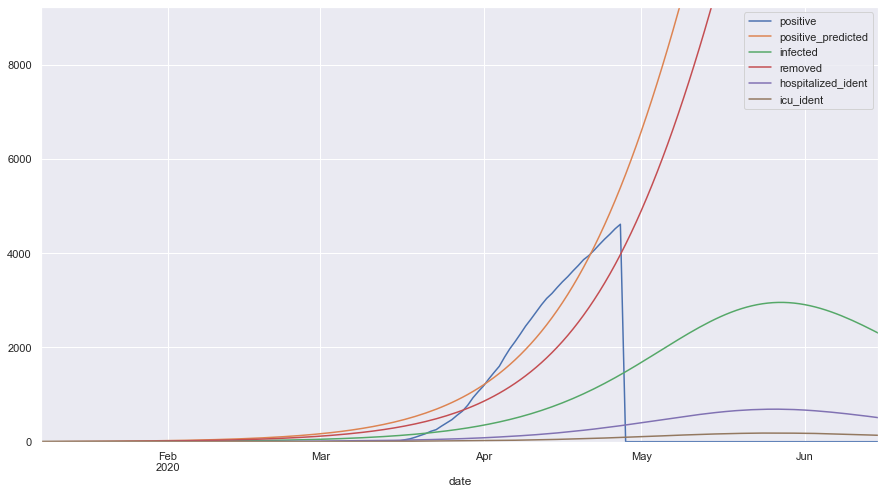

In [13]:
dfq = get_state_df(dfw, "ITA")
ccd = CurrentCasesFromDeaths()
dfq = ccd.add_positive_estimate(dfq)
N=60000 
R0=0
x0 = (0.33821616, 0.15247499, 2.6568561)
sf = SIR()
c = ccd.fit_series/1000
(N, I0, R0, beta, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[-1.91354283e-06, -7.34506141e-04,  2.29717226e-05,
        -2.18503951e-06],
       [-5.76036675e-07, -2.14521812e-03, -2.99267726e-04,
         7.69222165e-05],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-1.95027183e-07, -6.59919486e-04, -2.11667658e-04,
         2.92719205e-05]])
     fun: 465005.5399434458
 message: 'Optimization terminated successfully.'
    nfev: 1022
     nit: 17
  status: 0
 success: True
       x: array([3.10249377e-05, 7.21477206e-01, 5.69782048e-01, 8.37372270e-04])
######################################################################
Day 0 = 2019-12-21 00:00:00  (today=155)
Doubling time is about 3.23 days
Recovery time is about 1.22 days
Estimated initial infection was order of 0 poeple


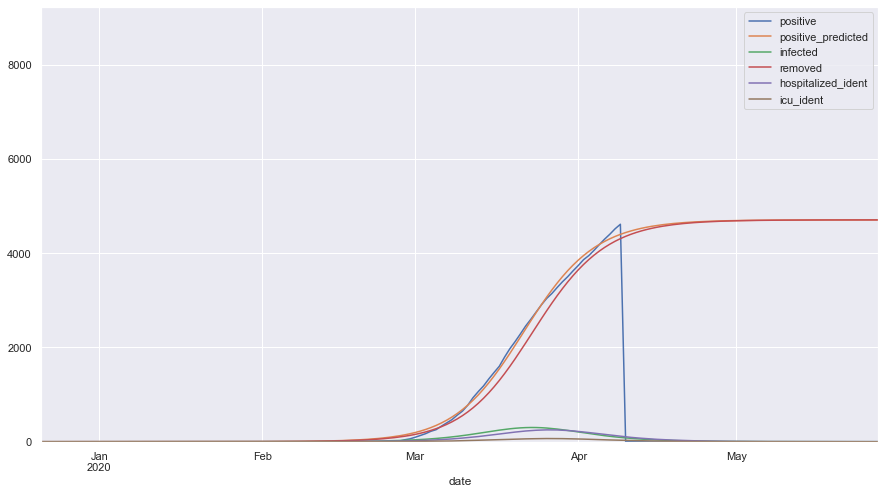

In [14]:
N=60000 
x0 = (4.13379338e-05, 7.42328935e-01, 5.71938181e-01, 2.09353947e-04)  # alpha, beta0, gamma, I0
c = ccd.fit_series/1000
start_date = dfq.date.values[0] - pd.Timedelta(days=ccd.shift)
sf = SIR4()
(N, I0, R0, beta0, alpha, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta0, alpha, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[-5.97986419e-04,  4.20878743e-04,  9.44235914e-02],
       [-1.42729943e-04,  7.29769883e-07,  3.05512868e-04],
       [-3.79018739e-04,  4.80060396e-04,  1.26930852e-01]])
     fun: 7940067.303261292
 message: 'Optimization terminated successfully.'
    nfev: 491
     nit: 12
  status: 0
 success: True
       x: array([0.21563282, 0.15023699, 1.54125394])
######################################################################
Day 0 = 2019-12-21 00:00:00  (today=155)
Doubling time is about 3.21 days
Recovery time is about 4.61 days
Estimated initial infection was order of 1,541 poeple


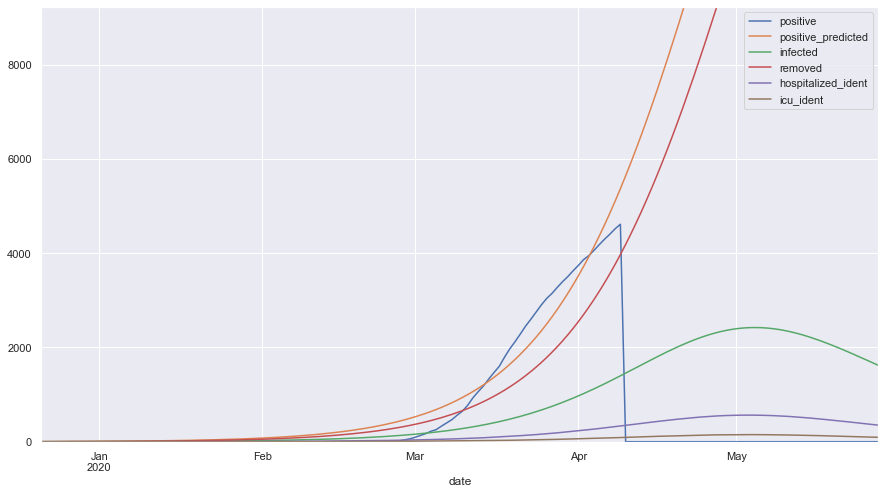

In [15]:
dfq = get_state_df(dfw, "ESP")
ccd = CurrentCasesFromDeaths()
dfq = ccd.add_positive_estimate(dfq)
N=47000
R0=0
x0 = (0.2262658 , 0.14456682, 0.43210381 )
sf = SIR()
(N, I0, R0, beta, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[-8.33739380e-07, -4.54653427e-03, -3.08063112e-03,
         1.27428498e-06],
       [-1.86777975e-06, -3.35365629e-04,  1.29329936e-05,
        -2.38521302e-09],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-2.45346797e-07, -1.84447757e-03, -1.50662968e-03,
         5.42841103e-07]])
     fun: 208846.00330110476
 message: 'Optimization terminated successfully.'
    nfev: 1796
     nit: 30
  status: 0
 success: True
       x: array([4.11381583e-05, 6.95513254e-01, 5.06826213e-01, 1.79539456e-05])
######################################################################
Day 0 = 2019-12-21 00:00:00  (today=155)
Doubling time is about 3.21 days
Recovery time is about 1.37 days
Estimated initial infection was order of 0 poeple


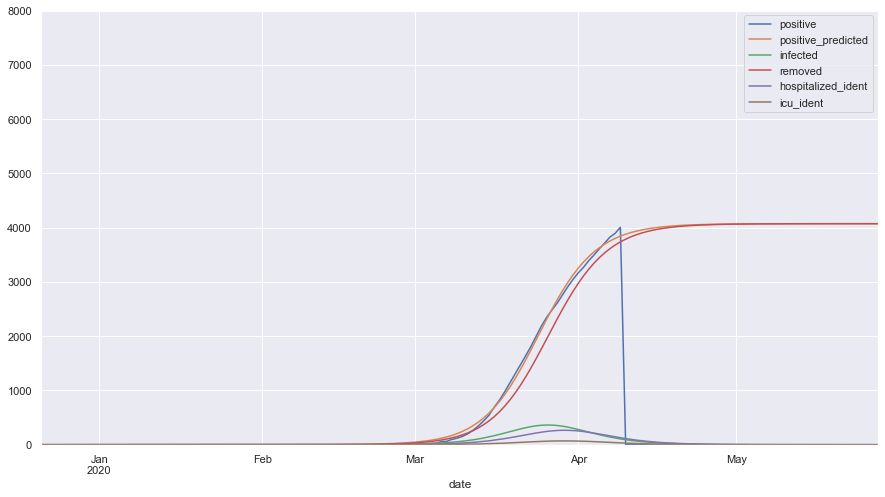

In [16]:
N=47000 
x0 = (6.23470525e-05, 7.62581143e-01, 5.41117221e-01, 1.10624820e-06)  # alpha, beta0, gamma, I0
c = ccd.fit_series/1000
start_date = dfq.date.values[0] - pd.Timedelta(days=ccd.shift)
sf = SIR4()
(N, I0, R0, beta0, alpha, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta0, alpha, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])